# The CosmoClassifier
In this project, I have used the Data Release 18 version of Sloan Digital Sky Survey (SDSS) dataset to train a classifier algorithm to predict whether the given credentials corresponds to a Galaxy(class 0), Star(class 1) or Quasar(class 2). This notebook is used as a playground to test different hyperparameter settings as well as preprocessing approaches. 

Importing the libraries

In [34]:
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import train_test_split,learning_curve,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Basic Preprocessing

Importing the dataset

In [22]:
df_raw = pd.read_csv("Datasets/SDSS_DR18.csv")

Dropping the identifier columns which may lead to data leakage

In [23]:
df_raw = df_raw.drop(columns=["objid", "specobjid", "run", "rerun", "camcol", "field", "plate", "mjd", "fiberid"])

Identifying and mapping the classes

In [24]:
print(df_raw["class"].value_counts())
df_1 = df_raw.copy()

class
GALAXY    52343
STAR      37232
QSO       10425
Name: count, dtype: int64


In [25]:
df_1["class"] = df_1["class"].map({
  "GALAXY":0,
  "STAR":1,
  "QSO":2
})
df_1["class"].head(10)

0    0
1    1
2    0
3    1
4    1
5    1
6    1
7    0
8    0
9    1
Name: class, dtype: int64

Checking for null values

In [26]:
df_1.isna().value_counts()

ra     dec    u      g      r      i      z      petroRad_u  petroRad_g  petroRad_i  petroRad_r  petroRad_z  petroFlux_u  petroFlux_g  petroFlux_i  petroFlux_r  petroFlux_z  petroR50_u  petroR50_g  petroR50_i  petroR50_r  petroR50_z  psfMag_u  psfMag_r  psfMag_g  psfMag_i  psfMag_z  expAB_u  expAB_g  expAB_r  expAB_i  expAB_z  redshift  class
False  False  False  False  False  False  False  False       False       False       False       False       False        False        False        False        False        False       False       False       False       False       False     False     False     False     False     False    False    False    False    False    False     False    100000
Name: count, dtype: int64

No null values were found, so we are going to skip dropping nulls.

Copying the dataset and specifying the target & feature columns

In [27]:
df = df_1.copy()
column_names = df.columns
y = df.iloc[:,-1].to_numpy()      # Target Column
x = df.iloc[:,:-1]    # Feature Column
feature_names = x.columns
x = x.to_numpy()

## ML Preprocessing, Model training, Evaluation 

Performing train-test split

In [28]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=2/10,random_state=120,shuffle=True,stratify=y)

Defining the pipeline and the model

In [32]:
# RF, SVC, LR, XGB
rf_model = RandomForestClassifier(random_state=40)
svc_model = SVC(random_state=41)
lr_model = LogisticRegression(random_state=42,max_iter=10_000)
xgb_model = XGBClassifier(random_state=43)

pca = PCA(random_state=44)
lda = LDA(n_components=2)

pipe = Pipeline([
  ("impute",SimpleImputer(strategy="median")),
  ("scale",StandardScaler()),
  ("smote",SMOTE(random_state=101)),
  ("dimen",pca),
  ("model",rf_model)
])

Performing Randomized Search CV

In [33]:
param_list = [
  { # Random Forest, PCA On
    "model": [rf_model],"model__n_estimators":np.arange(150,650,100),
    "model__max_depth":np.arange(7,14,2), "dimen" : [pca], "dimen__n_components":[18,20,22]
  },

  # { # SVC, No dimen. reduction
  #   "model": [svc_model], "model__C":[0.01,0.1,1,10], "model__kernel":["rbf"], "model__gamma":[0.01,0.1,1,10],
  #   "dimen":["passthrough"]
  # },

  { # Logistic Regression, No dimen. reduction, l1 penalty, `saga` solver
    "model": [lr_model], "model__C": [0.01,0.1,1,10], "model__penalty":["l1"], "model__solver":["saga"],
    "dimen": ["passthrough"]
  },
  { # Logistic Regression, No dimen. reduction, l2 penalty, `lbfgs` solver
    "model": [lr_model], "model__C": [0.01,0.1,1,10], "model__penalty":["l2"], "model__solver":["lbfgs"],
    "dimen": ["passthrough"]
  },
  { # XGBoost, PCA On
    "dimen": [pca], "dimen__n_components": [18,20,22],
    "model": [xgb_model], "model__n_estimators" : np.linspace(500,1100,3,dtype=int),"model__learning_rate": [0.01,0.1], "model__max_depth":np.arange(7,14,3)
  },
  { # XGBoost, LDA On
    "dimen": [lda],
    "model": [xgb_model], "model__n_estimators" : [500,700,900],"model__learning_rate": [0.01,0.1], "model__max_depth":np.arange(7,14,3)
  }
]

rscv = RandomizedSearchCV(
  estimator=pipe,param_distributions=param_list,n_iter=8,cv=5,n_jobs=-1,random_state=50,refit=True
)

rscv.fit(x_train,y_train)
estimator = rscv.best_estimator_
score = rscv.best_score_
config = rscv.best_params_
print(f"Best Configuration:\n{config}")
print(f"Best Score = {score}")

/Users/Sakib/.venvs/jupyterfix/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Configuration:
{'model__n_estimators': np.int64(1100), 'model__max_depth': np.int64(13), 'model__learning_rate': 0.1, 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...), 'dimen__n_components': 20, 'dimen': PCA(random_state=44)}
Best Score = 0.98765


As we can see, the **XGBoost** algorithm paired with PCA dominated the randomized search with the best score of **0.9875**, which is a great score overall. Now, let's calculate the **Classification Report** to find out other metrices.

In [36]:
y_true = y_test
y_pred = rscv.predict(x_test)
print(classification_report(y_true=y_true,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10469
           1       0.99      1.00      0.99      7446
           2       0.97      0.96      0.97      2085

    accuracy                           0.99     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.99      0.99      0.99     20000



#### PCA Loading heatmap

In [45]:
pca = estimator.named_steps["dimen"]
comp_df = pd.DataFrame(pca.components_,index=[f"PC{i+1}" for i in range(pca.n_components_)],columns=feature_names)
exp_var = pca.explained_variance_

def mod(x):
  return x * np.sqrt(exp_var)
loading_df = comp_df.copy().apply(mod)
loading_df.head(3)

,ra,dec,u,g,r,i,z,petroRad_u,petroRad_g,petroRad_i,...,psfMag_r,psfMag_g,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift
PC1,0.015068,0.064596,0.757354,1.032867,1.027231,0.044242,0.030685,-0.165071,-0.321211,-0.315436,...,0.680507,0.580676,0.036669,0.026449,-0.182620,-0.019467,-0.041092,0.010513,0.009936,0.953631
PC2,0.035250,-0.005645,0.286132,0.051079,-0.072749,-0.029934,-0.029643,0.366168,0.655026,0.642474,...,0.580908,0.676651,-0.006289,-0.016463,-0.083846,-0.252008,-0.203290,-0.026108,-0.025958,-0.352012
PC3,0.003487,0.004921,-0.004796,-0.009656,-0.013238,0.701161,0.715387,0.015478,0.031724,0.032044,...,0.014318,0.017999,0.702118,0.715971,0.000755,-0.001605,0.001620,0.702053,0.715878,-0.006495


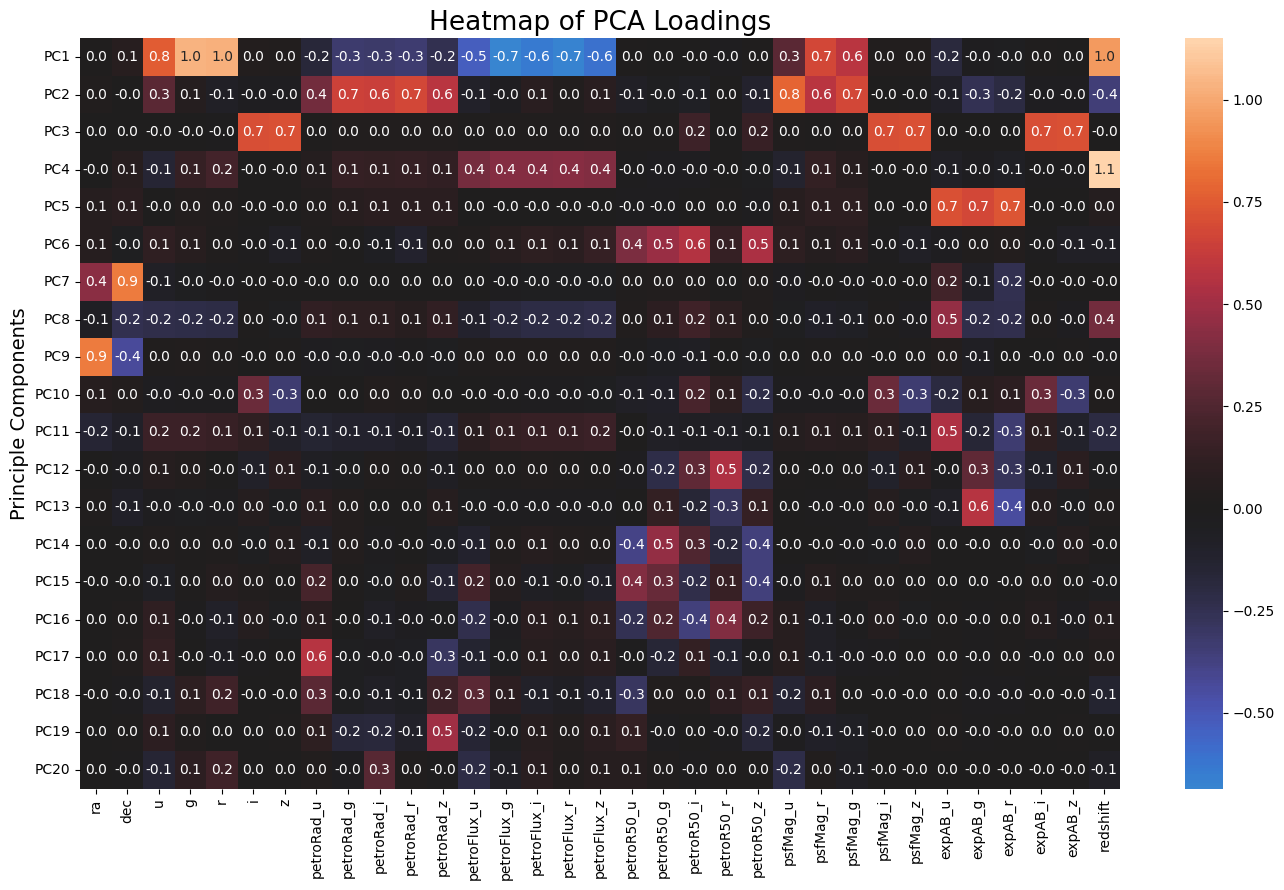

In [46]:
plt.figure(figsize=(14,9))
sns.heatmap(loading_df,cmap="icefire",annot=True,fmt=".1f",center=0)
plt.ylabel("Principle Components",fontdict={"fontsize":14})
plt.title("Heatmap of PCA Loadings",fontdict={"fontsize":19})
plt.tight_layout()
plt.show()

This heatmap visualizes the PCA loadings for 20 Principal Components (PCs) across numerous features. PC1 and PC2 are primarily defined by the spectral bands (g, r, i etc.) and flux values, capturing the bulk of the variance. Loadings quickly drop to near-zero by PC11, indicating that the first 10-12 components are sufficient for dimension reduction and interpretation in this dataset.

#### Learning Curve

Let's plot the **Learning Curve** plot to understand whether the model is fit well or is underfitting/overfitting.

In [47]:
train_size, train_acc, val_acc = learning_curve(
  estimator,x_train,y_train,train_sizes=np.linspace(0.1,1.0,10),
  cv=5,n_jobs=-1,random_state=9,shuffle=True
)

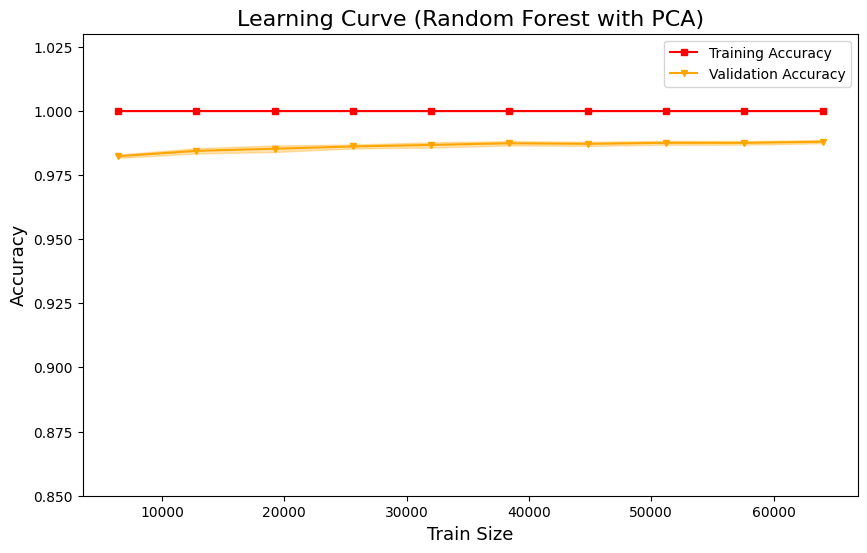

In [48]:
train_mean = np.mean(train_acc, axis=1)
train_std = np.std(train_acc,axis=1)
val_mean = np.mean(val_acc,axis=1)
val_std = np.std(val_acc,axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_size, train_mean, color="red",marker="s",markersize=4,label="Training Accuracy")
plt.fill_between(train_size, train_mean + train_std , train_mean - train_std, color="red",alpha=0.3)

plt.plot(train_size, val_mean, color="orange",marker="v",markersize=4,label="Validation Accuracy")
plt.fill_between(train_size, val_mean + val_std, val_mean - val_std, color="orange",alpha=0.3)

plt.title("Learning Curve (Random Forest with PCA)",fontdict={"fontsize":16})
plt.xlabel("Train Size",fontdict={"fontsize":13})
plt.ylabel("Accuracy",fontdict={"fontsize":13})
plt.ylim(0.85,1.03)
plt.legend()
plt.show()


This learning curve for a Random Forest model after applying PCA shows excellent performance, with both Training Accuracy (red) and Validation Accuracy (orange) consistently high, clustering around 0.98. Crucially, the minimal gap between the two curves indicates that the model exhibits low variance and is not significantly overfitting the data, even at smaller training sizes (around 10,000 samples). The validation accuracy appears to have converged, suggesting that further increases in the training set size are unlikely to yield substantial improvements in generalization performance. 

## Summary
In this notebook, we have performed proper tests to develop the best possible model for our classification task. We will take the code from here to built `fit.py` script from the ground up.

Check out `research_2.ipynb` file to see the feature reductions I tried out. It is a crucial step to make the app realistic and actually useful.